<a href="https://colab.research.google.com/github/aakhterov/ML_algorithms_from_scratch/blob/master/A_B_testing_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 0 - Getting Started

"Graffit" is a mobile app for listening to and watching various audio and video sources, making bookmarks, and transcribing audio fragments into text.

A graffit's team uses social media advertising to attract potential customers to their site. A product manager thinks the current ad banner can be improved and increase CTR. A new banner is ready but the product manager wants to conduct an A/B test before launching.

**Note**: The notebook based on the AB Testing Course on https://www.datainterview.com

In [54]:
from datetime import datetime
import math
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from matplotlib.ticker import MultipleLocator
from statsmodels.stats.power import TTestIndPower, tt_ind_solve_power, zt_ind_solve_power
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.proportion import proportions_chisquare, confint_proportions_2indep
from scipy.stats import norm

from google.colab import drive
drive.mount('/content/drive/')

# Disable warnings
from warnings import filterwarnings
filterwarnings('ignore')

SEED = 123
np.random.seed(SEED)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Step 1 - Understand the Business Problem

The first crucial step in AB testing is to understand the business problem. A vital aspect in understanding the business problem is exploring the data.

In [55]:
# Load pretest data
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data/a_b_test_ctr.csv")
df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%y')
df.head()

,Date,Impressions,Clicks,is_new_banner
0,2023-09-01,15159,193,0
1,2023-09-02,15014,90,0
2,2023-09-03,15219,148,0
3,2023-09-04,14970,146,0
4,2023-09-05,15016,125,0


In [56]:
df['CTR'] = df['Clicks']*100/df['Impressions'] # calculate CTR
current_ctr_mean = df['CTR'].mean().round(2)
print(f"The current average CTR is {current_ctr_mean}%")

The current average CTR is 0.84%


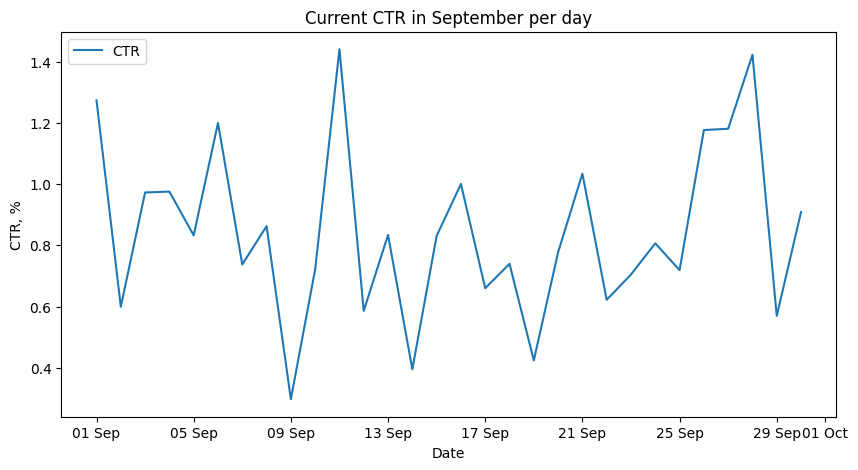

In [57]:
# Let's plot the CTRs per day
_, ax = plt.subplots(figsize=(10,5))
sns.lineplot(x=df['Date'], y=df['CTR'])
plt.legend(labels=["CTR"])
plt.ylabel('CTR, %')
ax.xaxis.set_major_formatter(DateFormatter("%d %b"))
plt.title('Current CTR in September per day')
plt.show()

# Step 2 - State the Hypothesis

The second step of the experiment is to state the hypothesis. This is followed by setting parameter values such as the significance level (alpha), statistical power and minimum detctable effect (MDE).

$ H_0 $: The CTRs for the new banner and the old one are the same.

$ H_a $ : The CTRs for the new banner and the old one are different.

In [58]:
alpha = 0.05 # the segnificane level
power = 0.80 # the statistical power
mde = 0.20 # the minimum detectable effect (MDE)

p1 = current_ctr_mean # the current value of the CTR average
p2 = current_ctr_mean * (1 + mde) # the desired value of the CTR average

print(f"The current value of the CTR average: {p1}%\nThe desired value of the CTR average: {p2}%")

The current value of the CTR average: 0.84%
The desired value of the CTR average: 1.008%


# Step 3 - Design the Experiment

The third step of the experiment is the design the experiment which involves determining the randomization unit, calculating the sample size and determining the experiment duration. In our case, the social media tools will be responsible for the randomization. However, we still need to know the sample size and the experiment duration.

## Calculate sample size

In [59]:
effect_size = sm.stats.proportion_effectsize(p2/100, p1/100)
# Here use the following eq: 2 * (np.arcsin(np.sqrt(p2/100)) - np.arcsin(np.sqrt(p1/100)))
print(f"Effect size of the two (current CTR and desired CTR) samples: {effect_size:.3f}")

Effect size of the two (current CTR and desired CTR) samples: 0.018


In [60]:
# Calculate the sample size
nobs1 = zt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power)
n = math.ceil(nobs1) # the number of observations in the 1th sample
N = 2*n # the total number of observations
print(f"Number of observations in the 1th sample: {n}\nTotal number of observations: {N}")

Number of observations in the 1th sample: 50812
Total number of observations: 101624


## Calculate experiment duration

In [61]:
impessions_mean = df['Impressions'].mean()
dur = math.ceil(N/impessions_mean)
print(f"The average impressions per day: {impessions_mean}")
print(f"To achieve the required sample size it's needed {dur} days")

The average impressions per day: 14997.033333333333
To achieve the required sample size it's needed 7 days


# Step 4 - Run the Experiment

We will take a look at the step that involves running an experiment.

In [62]:
# Load data that was obtained after 7-days test
df_after = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data/a_b_after_test_ctr.csv")
df_after['Date'] = pd.to_datetime(df_after['Date'], format='%d.%m.%y')
df_after.head()

,Date,Impressions,Clicks,is_new_banner
0,2023-10-15,7209,54,0
1,2023-10-16,7456,84,0
2,2023-10-17,7468,36,0
3,2023-10-18,7586,46,0
4,2023-10-19,7623,54,0


In [63]:
control_df = df_after[df_after['is_new_banner']==0] # The data of the control sample
treatment_df = df_after[df_after['is_new_banner']==1] # The data of the treatment sample

In [64]:
control_df['CTR'] = control_df['Clicks']*100/control_df['Impressions'] # calculate CTR of the control group
treatment_df['CTR'] = treatment_df['Clicks']*100/treatment_df['Impressions'] # calculate CTR of the treatment group
control_size = control_df['Impressions'].sum() # The number of observations in the control group
control_count = control_df['Clicks'].sum() # The number of successes in the control group
control_ctr_mean = control_df['CTR'].mean().round(2) # The average CTR in the control group
treatment_size = treatment_df['Impressions'].sum() # The number of observations in the treatment group
treatment_count = treatment_df['Clicks'].sum() # The number of successes in the treatment group
treatment_ctr_mean = treatment_df['CTR'].mean().round(2) # The average CTR in the treatment group
print(f"The control group average CTR is {control_ctr_mean}%. The control size is {control_size}.")
print(f"The treatment group average CTR is {treatment_ctr_mean}%. The treatment size is {treatment_size}.")

The control group average CTR is 0.79%. The control size is 52450.
The treatment group average CTR is 1.32%. The treatment size is 52790.


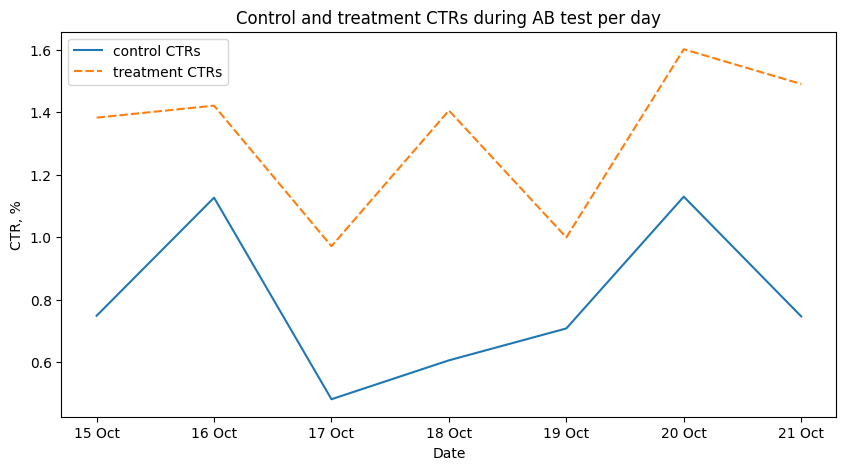

In [65]:
# Let's plot the CTRs in the control and treatment groups per day
df = pd.DataFrame({
    "control CTRs": control_df['CTR'],
    "treatment CTRs": treatment_df['CTR'].reset_index(drop=True)
}) # make auxiliary DataFrame
df.index = control_df['Date']

_, ax = plt.subplots(figsize=(10,5))
sns.lineplot(data=df, ax=ax)
plt.ylabel('CTR, %')
ax.xaxis.set_major_formatter(DateFormatter("%d %b"))
plt.title('Control and treatment CTRs during AB test per day')
plt.show()

# Step 5 - Assess Validity Threats

In this step, we should conduct checks to avoid type 1 or 2 errors. It includes the checks for such threats as Novelty Effect, Holiday (Weekend) Effect, Survivorship Bias, Sample Ratio Mismatch (SRM), and others and implies conducting the AA tests and the chi-square tests.

These checks should be conducted prior to the AB test to ensure that there is no underlying difference between the control and treatment.

In our case, the social media tools will be responsible for avoiding the threats. Here, for the training goals, we will conduct the chi-square test for detecting Sample Ratio Mismatch (SRM).


## Sample Ratio Mismatch (SRM)

Let's imagine that we wanted to split users into the control and treatment groups with a ratio of 1:1. We (not social media) have made randomization and got not equal number of users in each group. We want to check if this difference is statistically significant or not. In that case, we will conduct the chi-square test for sample ratio mismatch (SRM).

In [68]:
# Let's check for sample ratio mismatch (SRM)

# Get the observed and expected counts in the experiment
observed = [control_size, treatment_size] # imagine that we know the control and treatment sample size before AB test.
expected = [int(control_size + treatment_size)/2]*2
print(f"Observed sizes are {observed}\nExpected sizes are equal - {expected}\n")

# perform Chi-Square Goodness of Fit Test
chi_stats, p_value = stats.chisquare(f_obs=observed, f_exp=expected)

print('Ho: The ratio of samples is 1:1.')
print('Ha: The ratio of samples is not 1:1.\n')
print(f'Significance level: {alpha}')

print(f'Chi-Square = {chi_stats:.3f} | P-value = {p_value:.3f}')

print('\nConclusion:')
if p_value < alpha:
  print('Reject Ho and conclude that there is statistical significance in the ratio of samples not being 1:1. Therefore, there is SRM.')
else:
  print('Fail to reject Ho. Hence, there is no SRM.')

Observed sizes are [52450, 52790]
Expected sizes are equal - [52620.0, 52620.0]

Ho: The ratio of samples is 1:1.
Ha: The ratio of samples is not 1:1.

Significance level: 0.05
Chi-Square = 1.098 | P-value = 0.295

Conclusion:
Fail to reject Ho. Hence, there is no SRM.


# Step 6 - Conduct Statistical Inference

In this step we will conduct the chi-square test to analyze the AB test results and reject or fail to reject the null hypothesis. After that, we will calculate the confidence interval.

Once again:

$ H_0 $: The CTRs for the new banner and the old one are the same.

$ H_a $ : The CTRs for the new banner and the old one are different.

In [74]:
chi2stat, p_value, _ = proportions_chisquare(count=[control_count, treatment_count], nobs=[control_size, treatment_size])

In [73]:
print(f'Significance level: {alpha}')
print(f'Chi-Square = {chi2stat:.3f} | P-value = {p_value:.3f}')

print('\nConclusion:')
if p_value < alpha:
  print('Reject Ho. Hence, there is statistical significance in the difference between CTRs for the new banner and the old one.')
else:
  print('Fail to reject Ho.')

Significance level: 0.05
Chi-Square = 70.762 | P-value = 0.000

Conclusion:
Reject Ho. Hence, there is statistical significance in the difference between CTRs for the new banner and for the old one.


In [93]:
# Compute the Confidence Interval of the Test
ci = confint_proportions_2indep(treatment_count, treatment_size, control_count, control_size, alpha=0.05)
lower = ci[0]*100
upper = ci[1]*100
lower_lift = lower / control_ctr_mean
upper_lift = upper / control_ctr_mean

In [94]:
# Print results
print('--------- Sample Sizes ----------')
print(f'Control: {control_size}')
print(f'Treatment: {treatment_size}')

print('\n--------- Clicks Counts (CTR) ----------')
print(f'Control: {control_count} ({control_ctr_mean:.2f}%)')
print(f'Treatment: {treatment_count} ({treatment_ctr_mean:.2f}%)')

print('\n--------- Differences ----------')
print(f'Absolute: {treatment_ctr_mean - control_ctr_mean:.3f}')
print(f'Relative (lift): {(treatment_ctr_mean - control_ctr_mean)*100 / control_ctr_mean:.1f}%')

print('\n--------- T-Stats ----------')
print(f'Chi-Square statistic: {chi2stat:2f}')
print(f'P-Value: {p_value:.2f}')

print('\n--------- Confidence Intervals ----------')
print(f'Absolute Difference CI: ({lower:.2f}, {upper:.2f})')
print(f'Relative Difference (lift) CI: ({lower_lift*100:.1f}%, {upper_lift*100:.1f}%)')

--------- Sample Sizes ----------
Control: 52450
Treatment: 52790

--------- Clicks Counts (CTR) ----------
Control: 416 (0.79%)
Treatment: 699 (1.32%)

--------- Differences ----------
Absolute: 0.530
Relative (lift): 67.1%

--------- T-Stats ----------
Chi-Square statistic: 70.762199
P-Value: 0.00

--------- Confidence Intervals ----------
Absolute Difference CI: (0.41, 0.66)
Relative Difference (lift) CI: (51.6%, 83.0%)
